# Master-Thesis 

Summary:  
Find mysterious soil property corresponding to soil-moisture behaviours. First Idea is to look at soil-moisture content after a minimum of 10 mm precipitation occured. Analyse the drying behaviours of the soil in the dry period after the rain event. 

# Table-of-content  

[AOI](#AOI)  



## Modul imports

In [34]:
#Notebook wird imports
from ipyleaflet import Map, GeoJSON, basemaps, Popup
from ipywidgets import HTML
from IPython.display import Image, IFrame
import ee
ee.Initialize()

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import cluster
from skimage import io, morphology, measure
from osgeo import gdal, gdal_array
gdal.UseExceptions()
gdal.AllRegister()


In [40]:
import os
import numpy as np


## Functions

In [2]:
#Get TileLayerurl from ee to plot on ipyleaflet
def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)


# AOI

The area of interest is the hessisches Ried. The shape is digitized from a screnshot taken from http://atlas.umwelt.hessen.de/servlet/Frame/atlas/naturschutz/naturraum/karten/m_3_2_1.htm . I found no better source. Info: The HLNUG is selling this shapes there's no open source map.

In [23]:
# Load AOI from GEE as FeatureCollection
ried_225_222 = ee.FeatureCollection('users/tillmueller1990/ried_225_222') # Use this but the boundary isn't that precise at borders, got it from wms layer 

#Get geometry and convert it to GeoJSON for visualisation purpose 
ried_geometry = ried_225_222.geometry().getInfo() #dict object
ried_geometry = ee.Geometry.Polygon(ried_geometry['coordinates']) #cast to Geometry object
ried_geometry = ried_geometry.toGeoJSON() #get GeoJSON object

#get area of aoi
ried_area = ried_225_222.geometry().area().getInfo()
print("Hessisches Ried: Naturräumliche Einheiten 225 und 222, area: ca. ", ried_area/1000**2, "km²") #m² in km² 

#map properties
center, zoom = (49.7252978589571, 8.34580993652344), 9

#create basemap
map = Map(center = center, zoom = zoom, basemap=basemaps.Esri.NatGeoWorldMap)

#add Layer to map
ried = GeoJSON(data = ried_geometry, style = {'color': 'blue', 'opacity':1, 'fillOpacity':0.25}) #Create GeoJSON ipyleaflet object
map.add_layer(ried) #add layer to map

#display map
map


Hessisches Ried: Naturräumliche Einheiten 225 und 222, area: ca.  725.892726964547 km²


Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{…

# Remote sensed data

This work try to obtain the most data from osm remotely sensed products or self derived data.  
There are many properties affecting soil moisture:  
1. Soil type  (X)
2. Organic content  ( )
3. Precipitation  (X)
4. Vegetation  (X)
5. Altitude  (X)
6. Sun radiation (X)
7. Cloudcover  ( )
8. Soil temperature (X)
9. Air temperature (X)
10. Evaporation / Evapotranspiration (X)
11. Wind relation (X)
12. ? ( )

A brief overview of available datasets:  

### Earth Engine Datasets
#### NASA-USDA Global Soil Moisture Data https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_soil_moisture
revesit : 3days ; resoltion : 0.25 arc degrees (~25km)
Surface soil moisture  
Subsurface soil moisture  
Soil moisture profile  
Surface soil moisture anomaly  
Subsurface soil moisture anomaly  
#### CHIRPS Daily: Climate Hazards Group InfraRed Precipitation with Station Data https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY
revesit : daily ; resolution : 0.05 arc degrees (~5km)  
precipitation mm 
####  GLDAS-2.1: Global Land Data Assimilation System https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V021_NOAH_G025_T3H
revesit : 3 H , resolotion : 0.25 arc degrees (~25km)  
Albedo  
Average surface skin temperature  
Plant canopy surface water  
Canopy water evaporation  
Direct evaporation from bare soil  
Evapotranspiration  
Downward long-wave radiation flux  
Net long-wave radiation flux  
Potential evaporation rate  
Pressure 
Specific humidity  
Heat flux  
Sensible heat net flux  
Latent heat net flux  
Storm surface runoff  
Baseflow-groundwater runoff  
Snow melt  
Total precipitation rat  
Rain precipitation rate  
Root zone soil moisture  
Snow depth water equivalent  
Downward short-wave radiation flux  
Snow depth  
Snow precipitation rate  
Soil moisture  
Soil temperature  
Net short wave radiation flux  
Air temperature  
Transpiration  
Wind speed  

### Other Datasets

#### Bodenübersichtskarte von Hessen http://bodenviewer.hessen.de/mapapps/resources/apps/bodenviewer/index.html?lang=de
Year: 1997, scale: 1 : 500 000 bis zu 1:5000 




# Soil Type
Soil type is important because different kind of soils have different potentials to release water at same weather conditions.   
![Image of Yaktocat](http://www.soilmanagementindia.com/wp-content/uploads/2017/03/clip_image002-5.jpg)  

I found no source for downloading a soil map in any format there are only wms layer and bodenviewer of HLNUG so i take a screenshot from HLNUG Bodenviewe.  
The smallest scale fits on one screenshot. The other two scales (1:50.000 and 1:5.000) need several screenshots. Than you have to stich the images with e.g. autosticht together.  

In [38]:
IFrame(src='http://bodenviewer.hessen.de/mapapps/resources/apps/bodenviewer/index.html?lang=de&center=550000%2C5595000%2C25832&lod=3', width=1400, height=600)

## All Band Classifier (KMeans)
Save this images as .tiff or .png to preserve the 3 bands. Because we need to make a KMeans classification and with more bands the classification is better. The number of possible soil classes are 32 + 1 for the white background. 

Color: [255. 255. 255.]  >>  Objects: 1
Color: [220. 220. 148.]  >>  Objects: 11
Color: [238. 183.  77.]  >>  Objects: 33
Color: [255. 197. 210.]  >>  Objects: 229
Color: [183. 230. 246.]  >>  Objects: 108
Color: [255. 225. 166.]  >>  Objects: 127
Color: [232. 192. 164.]  >>  Objects: 56
Color: [233. 157. 255.]  >>  Objects: 62
Color: [223. 161. 115.]  >>  Objects: 9
Color: [255. 196.  77.]  >>  Objects: 186
Color: [248. 217. 113.]  >>  Objects: 56
Color: [238. 222.  77.]  >>  Objects: 73
Color: [255. 210. 239.]  >>  Objects: 2
Color: [248. 162. 204.]  >>  Objects: 53
Color: [136. 255.  77.]  >>  Objects: 28
Color: [216. 210. 178.]  >>  Objects: 85
Color: [173. 140. 125.]  >>  Objects: 4
Color: [216. 174. 153.]  >>  Objects: 22
Color: [195. 155.  77.]  >>  Objects: 16
Color: [220. 220. 220.]  >>  Objects: 30
Color: [239. 210. 255.]  >>  Objects: 40
Color: [214. 122. 210.]  >>  Objects: 10
Color: [195. 168. 115.]  >>  Objects: 6
Color: [206. 162. 141.]  >>  Objects: 8
Color: [239. 207. 

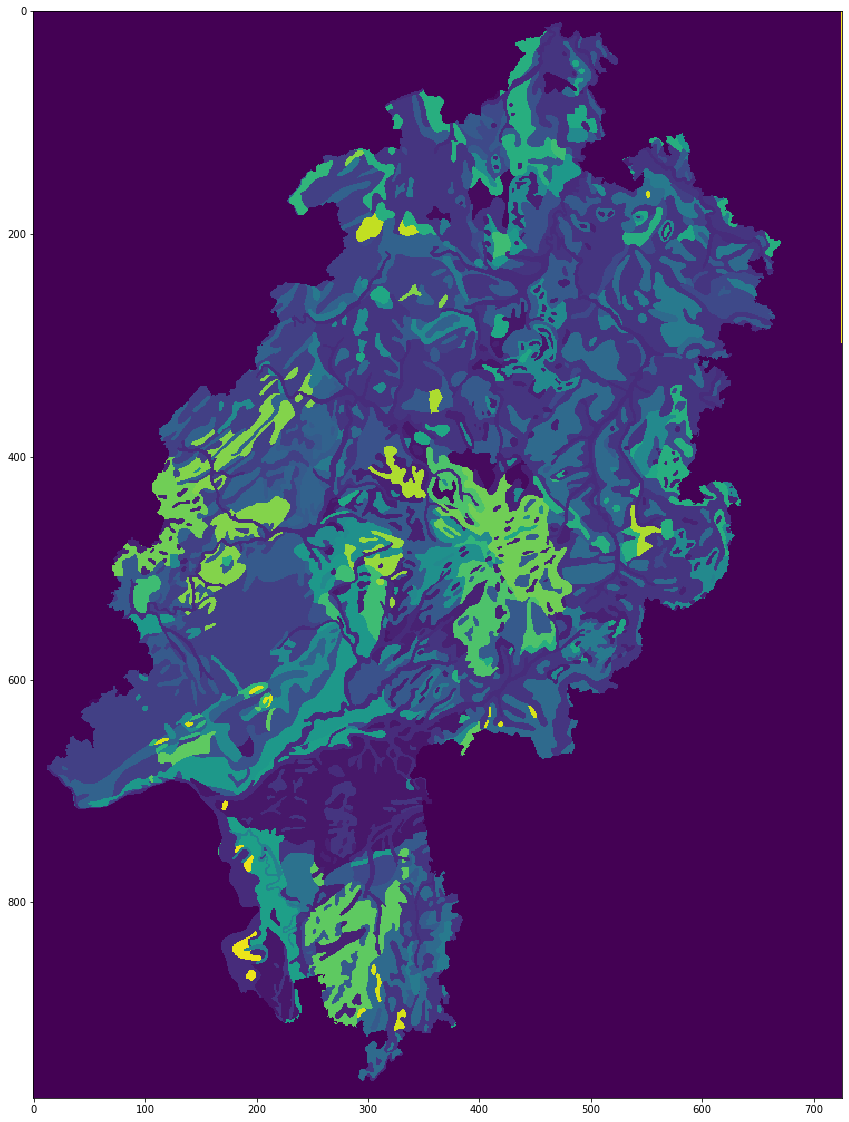

In [47]:
filepath = r'C:\Users\USER\Desktop\master-thesis-master\soil_map\results\great_hesse_soil_map_ref.tif'

#Load file in gdal
file = gdal.Open(filepath, gdal.GA_ReadOnly)

#Initialize an array of zeros with size of input
img = np.zeros((file.RasterYSize, file.RasterXSize, file.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(file.GetRasterBand(1).DataType))

#Loop over the number of bands in the image (img.shape[2]) insert values into the numpy array
for b in range(img.shape[2]):
    img[ : , : , b] = file.GetRasterBand(b + 1).ReadAsArray()

#Reshape array 
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

#based on this shape, we can build the input value
X = img[: , : , :3].reshape(new_shape)
#X = np.where(X==150, 255, X) Bad idea because other r ,g or b values may have same as black and gray
#X = np.where(X==0, 255, X) 

#Classifier Kmeans
k_means = cluster.KMeans(n_clusters=33)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

#Get statistic values
for i in np.unique(X_cluster):
    blobs = np.int_(morphology.binary_opening(X_cluster == i))
    color = np.around(k_means.cluster_centers_[i])
    count = len(np.unique(measure.label(blobs))) - 1
    print('Color: {}  >>  Objects: {}'.format(color, count))
    
#Plot the data
plt.figure(figsize=(20,20))
plt.imshow(X_cluster)

plt.show()


## Save Classification as GeoTiff 

In [ ]:
#Open input image again to get properties
file = gdal.Open(filepath)

#We need a single band
band = file.GetRasterBand(1)

#Convert it to an array
arr = band.ReadAsArray()

#Extract columns and rows to a list
[cols, rows] = arr.shape

#Set the output as Geotiff
format = "GTiff"
driver = gdal.GetDriverByName(format)

#Creates the output raster with the dimensions of the input raster
#outDataRaster = driver.Create("soil_map_hesse_classify_33.tiff", rows, cols, 1, gdal.GDT_Byte) -> activate this cell for saving image local

#Set the projection and extent of the data.
outDataRaster.SetGeoTransform(file.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(file.GetProjection())##sets same projection as input

#Write classification result to a single band raster image 
outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

#Calling FlushCache() to remove from memory and delete the data
outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)

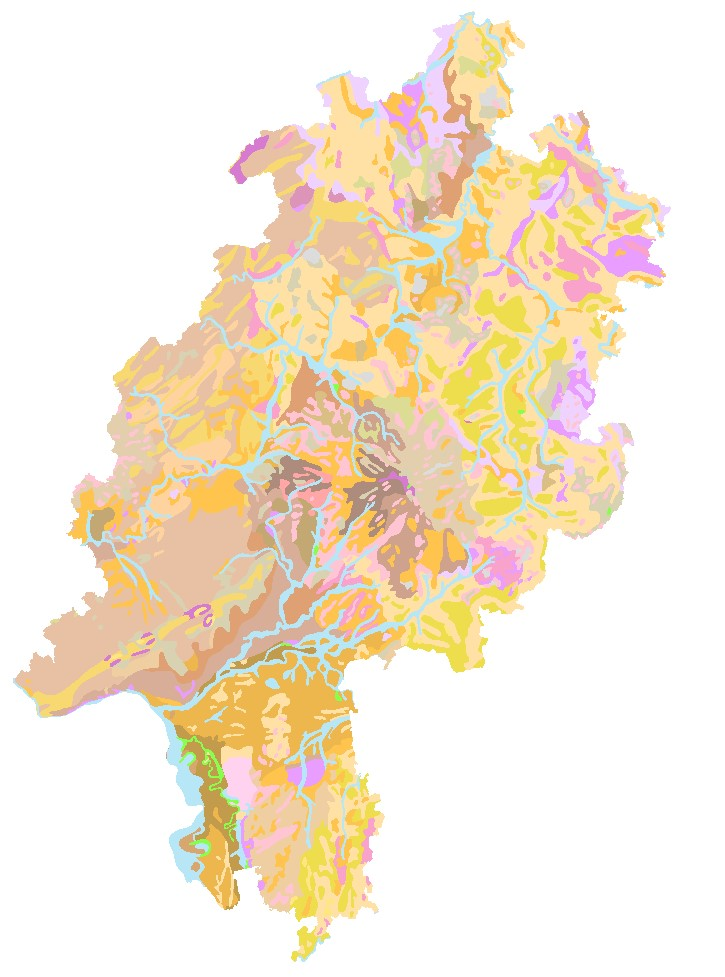

In [30]:
Image(filename=r'C:\Users\USER\Desktop\master-thesis-master\great_hesse_soil_map.jpg') 

In [ ]:
soil_map = ee.Image

In [ ]:
ried_viz = GetTileLayerUrl(ried_225_222.visualize())
In order to analyse the soil-moisture content we need to know more about the landuse and landcover. We are interested in fields with less or no vegetation.   
